In [2]:
from PIL import Image
import numpy as np
import os

def preprocess_images(image_folder, processed_folder, target_size=(64, 64)):
    # Create the processed folder if it doesn't exist
    if not os.path.exists(processed_folder):
        os.makedirs(processed_folder)
    
    for subdir in os.listdir(image_folder):
        subdir_path = os.path.join(image_folder, subdir)
        if os.path.isdir(subdir_path):
            # Create a corresponding subdirectory in the processed folder
            processed_subdir_path = os.path.join(processed_folder, subdir)
            if not os.path.exists(processed_subdir_path):
                os.makedirs(processed_subdir_path)
            
            for image_name in os.listdir(subdir_path):
                image_path = os.path.join(subdir_path, image_name)
                if os.path.isfile(image_path):  # Check if it's a file
                    image = Image.open(image_path)
                    image = image.resize(target_size)
                    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
                    
                    # Save the processed image
                    processed_image_path = os.path.join(processed_subdir_path, image_name)
                    Image.fromarray((image * 255).astype(np.uint8)).save(processed_image_path)

image_folder = 'images_smaller'
processed_folder = 'resized_images'
preprocess_images(image_folder, processed_folder)

In [3]:
import os
import shutil
import numpy as np
from sklearn.model_selection import train_test_split

# Define paths and labels
base_dir = "resized_images"
categories = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
splits = ['train', 'test', 'validation']

# Create directories for splits if they don't exist
for split in splits:
    split_path = os.path.join(base_dir, split)
    if not os.path.exists(split_path):
        os.makedirs(split_path)
    for category in categories:
        category_path = os.path.join(split_path, category)
        if not os.path.exists(category_path):
            os.makedirs(category_path)

# Split and move files
for category in categories:
    category_path = os.path.join(base_dir, category)
    if os.path.isdir(category_path):  # Ensure it's a directory
        images = os.listdir(category_path)
        
        # Perform the split: 60% train, 20% test, 20% validation
        train_images, temp_images = train_test_split(images, test_size=0.4, random_state=42)  # 60% train, 40% temp
        test_images, val_images = train_test_split(temp_images, test_size=0.5, random_state=42)  # 50% test, 50% validation from temp

        # Move images to corresponding directories
        for image in train_images:
            src = os.path.join(category_path, image)
            dest = os.path.join(base_dir, 'train', category, image)
            shutil.move(src, dest)

        for image in test_images:
            src = os.path.join(category_path, image)
            dest = os.path.join(base_dir, 'test', category, image)
            shutil.move(src, dest)

        for image in val_images:
            src = os.path.join(category_path, image)
            dest = os.path.join(base_dir, 'validation', category, image)
            shutil.move(src, dest)

# Verify splits
for split in splits:
    print(f"--- {split.upper()} SET ---")
    for category in categories:
        split_path = os.path.join(base_dir, split, category)
        print(f"{category}: {len(os.listdir(split_path))} images")


--- TRAIN SET ---
apple_pie: 600 images
bibimbap: 600 images
bread_pudding: 600 images
baklava: 600 images
beef_carpaccio: 600 images
beef_tartare: 600 images
breakfast_burrito: 600 images
baby_back_ribs: 600 images
beet_salad: 600 images
beignets: 600 images
--- TEST SET ---
apple_pie: 200 images
bibimbap: 200 images
bread_pudding: 200 images
baklava: 200 images
beef_carpaccio: 200 images
beef_tartare: 200 images
breakfast_burrito: 200 images
baby_back_ribs: 200 images
beet_salad: 200 images
beignets: 200 images
--- VALIDATION SET ---
apple_pie: 200 images
bibimbap: 200 images
bread_pudding: 200 images
baklava: 200 images
beef_carpaccio: 200 images
beef_tartare: 200 images
breakfast_burrito: 200 images
baby_back_ribs: 200 images
beet_salad: 200 images
beignets: 200 images


In [6]:
import os
import numpy as np
from PIL import Image
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

# Define paths for train and validation
train_dir = 'resized_images/train'
validation_dir = 'resized_images/validation'

# Function to load and preprocess images
def load_and_preprocess_images(folder):
    images = []
    labels = []
    for label in os.listdir(folder):
        label_folder = os.path.join(folder, label)
        if os.path.isdir(label_folder):
            for filename in os.listdir(label_folder):
                img_path = os.path.join(label_folder, filename)
                img = Image.open(img_path)  # Open the image
                img = img.resize((224, 224))  # Resize to 224x224 for VGG16 input
                img = img.convert('RGB')  # Ensure image is in RGB format
                img = np.array(img)  # Convert image to NumPy array
                images.append(img)  # Append the image
                labels.append(label)  # Append the label
    return np.array(images), np.array(labels)

# Load the training and validation data
X_train, y_train = load_and_preprocess_images(train_dir)
X_validation, y_validation = load_and_preprocess_images(validation_dir)

# Convert labels to integers (important for classification)
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_validation = le.transform(y_validation)

# Load the pre-trained VGG16 model (without the top classification layer)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Function to extract features using VGG16
def extract_features(model, images):
    # Preprocess images (convert to RGB and scale pixel values)
    images = preprocess_input(images)
    features = model.predict(images)
    return features.reshape(features.shape[0], -1)  # Flatten the features

# Extract features from the training and validation sets
X_train_features = extract_features(base_model, X_train)
X_validation_features = extract_features(base_model, X_validation)

# Initialize and train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_features, y_train)

# Make predictions on the validation set
y_pred = rf_classifier.predict(X_validation_features)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_validation, y_pred)}")
print("Classification Report:")
print(classification_report(y_validation, y_pred, target_names=le.classes_))


63/63 [==============================] - 129s 2s/step
Accuracy: 0.5095
Classification Report:
                   precision    recall  f1-score   support

        apple_pie       0.43      0.32      0.37       200
   baby_back_ribs       0.61      0.57      0.59       200
          baklava       0.43      0.54      0.48       200
   beef_carpaccio       0.56      0.76      0.64       200
     beef_tartare       0.42      0.42      0.42       200
       beet_salad       0.51      0.59      0.55       200
         beignets       0.52      0.71      0.60       200
         bibimbap       0.72      0.71      0.72       200
    bread_pudding       0.39      0.34      0.36       200
breakfast_burrito       0.41      0.14      0.20       200

         accuracy                           0.51      2000
        macro avg       0.50      0.51      0.49      2000
     weighted avg       0.50      0.51      0.49      2000



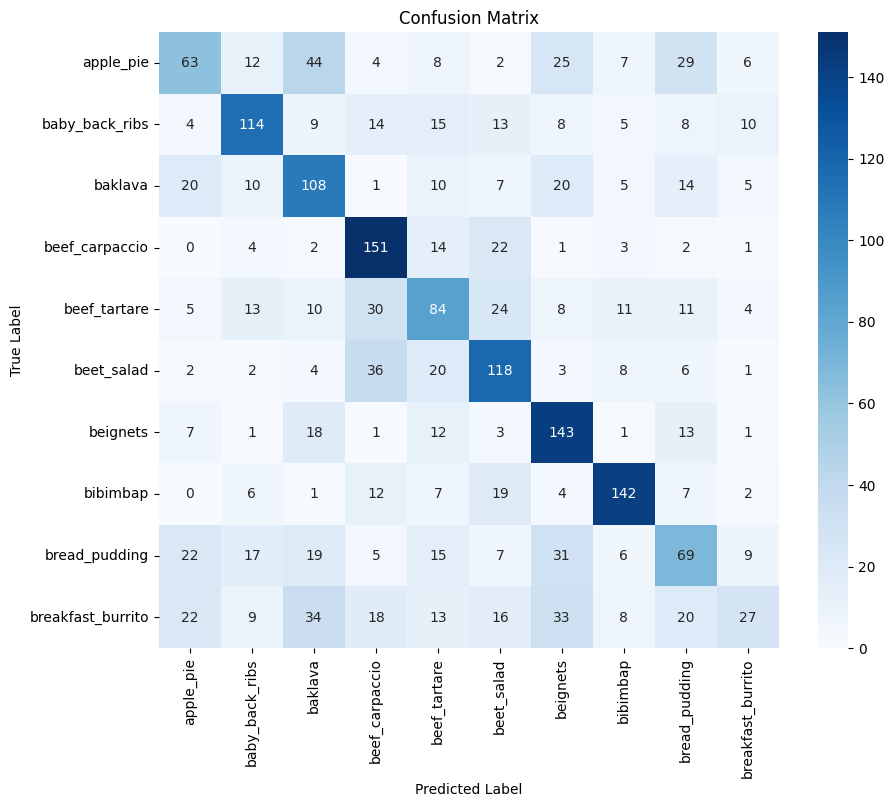

In [7]:
# confusion matrix

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_validation, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


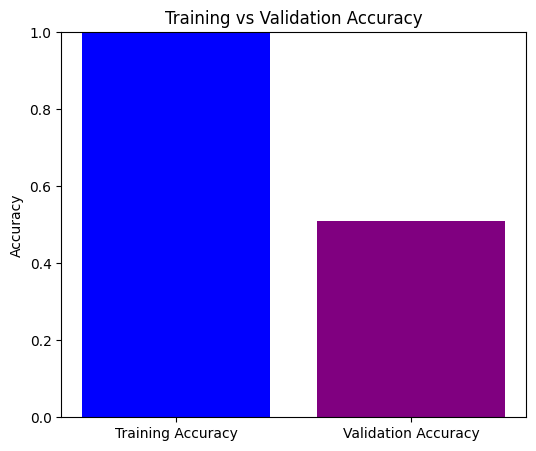

In [9]:
import matplotlib.pyplot as plt

labels = ['Training Accuracy', 'Validation Accuracy']
values = [rf_classifier.score(X_train_features, y_train), rf_classifier.score(X_validation_features, y_validation)]

plt.figure(figsize=(6, 5))
plt.bar(labels, values, color=['blue', 'purple'])
plt.ylabel("Accuracy")
plt.ylim(0, 1)  # Accuracy ranges from 0 to 1
plt.title("Training vs Validation Accuracy")
plt.show()
